<strong>The data I will be using is from Chicago police department and it contains all crimes reported during 2001 and 2016. The purpose of this <br>
analysis is  to find out where and when crimes occur. Is there a pattern in the occurenece of crimes? Are crimes affected by weather conditions  <br>
say: temperature? Is Chicago getting safer over these years, i.e., are crimes decreasing? What about certain types of crimes? Do certain types of  <br>
crimes show a differentpattern from others? We will try to address these questions in this notebook. </strong>

In [1]:
# First import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps                                # Used for plotting data on google maps using an API
from matplotlib import cm                   # To get certain color maps for plotting
from matplotlib.colors import to_hex
import ipywidgets as widgets                # Display widgets to help visualization
import json
from statsmodels.stats.weightstats import ttest_ind as sm_ttest
from scipy.stats import ttest_ind as sp_ttest
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

The data has been cleaned and wrangled to be used for the analysis. It is very large so here is an external link to the file: <br>
<a href="https://www.dropbox.com/s/t7bw99ef3sgwoht/crimes_new.csv?dl=0">Crime data download</a> <br>
This data set has all the entries for 8 major felonies and it's used for our analysis to find interesting trends or patterns.

In [3]:
# First read in the data
crimes=pd.read_csv('data/crime/crimes_new.csv', index_col=0, parse_dates=True)

In [4]:
# Check the data set
crimes.head(3)

Unnamed: 0       ID Case Number               Date.1                Block  IUCR Primary Type              Description Location Description  Arrest  Domestic  Beat  District FBI Code  X Coordinate  Y Coordinate  Year              Updated On   Latitude  Longitude                       Location        date  index  LATITUDE  LONGITUDE  ELEVATION        DATE  PRCP  SNOW  SNWD  TAVG  TMAX  TMIN weather_type
Date                                                                                                                                                                                                                                                                                                                                                                                                                            
2001-01-01           0  3272413    HK299011  2001-01-01 00:00:00  076XX S EMERALD AVE  0842        THEFT  AGG: FINANCIAL ID THEFT            RESIDENCE   False     False   621       6.0       06     1172658.0     1854465.0  2001  03/31/2006 10:03:38 PM  41.756087 -87.642812  (41.756086589, -87.642812325)  2001-01-01      0    41.995   -87.9336      201.8  2001-01-01   0.0   0.0  17.0  14.5  24.0   5.0      Unknown
2001-01-01           1  5508664    HN320275  2001-01-01 00:00:00  009XX N HARDING AVE  0266  SEX OFFENSE                PREDATORY            RESIDENCE   False      True  1112      11.0       02     1149843.0     1906023.0  2001  06/11/2007 03:52:33 PM  41.898041 -87.725087  (41.898040875, -87.725087394)  2001-01-01      0    41.995   -87.9336      201.8  2001-01-01   0.0   0.0  17.0  14.5  24.0   5.0      Unknown
2001-01-01           2  2743135    HJ380339  2001-01-01 00:00:00    039XX N MOZART ST  0266  SEX OFFENSE                PREDATORY            APARTMENT    True     False  1733      17.0       02     1156711.0     1926359.0  2001  08/17/2015 03:03:40 PM  41.953708 -87.699309  (41.953708013, -87.699309457)  2001-01-01      0    41.995   -87.9336      201.8  2001-01-01   0.0   0.0  17.0  14.5  24.0   5.0      Unknown

In [5]:
# Verify we have a datatime index
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3928123 entries, 2001-01-01 00:00:00 to 2017-11-12 23:30:00
Data columns (total 34 columns):
Unnamed: 0              int64
ID                      int64
Case Number             object
Date.1                  object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
date                    object
index                   int64
LATITUDE                float64
LONGITUDE               float64
ELEVATION               float64
DATE                    object
PRCP              

In [6]:
# Drop Date.1 column
crimes.drop(['Unnamed: 0', 'Date.1'], axis=1, inplace=True)

In [7]:
# Drop all rows in 2017 since it is not complete
crimes=crimes.loc['2001':'2016', :]

In [8]:
# First get the 8 felonies into a list for future plotting needs
crime_types=crimes['Primary Type'].value_counts().index.tolist()

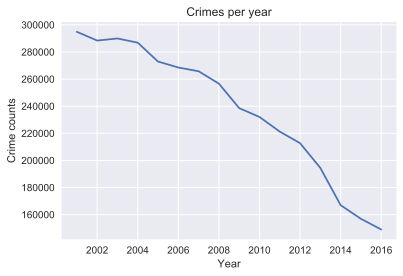

In [8]:
# Plot all crimes together as a time series
plt.figure(figsize=(6,4))
crimes['ID'].resample('A').count().plot()
plt.xlabel('Year')
plt.ylabel('Crime counts')
plt.title('Crimes per year')
plt.show()

<strong> Looking at the graph and all crimes as a whole, total crimes are going down from 2001 to 2016. But these numbers are just raw numbers <br>
and didn't take into account of the population change. Let's load a population table of Chicago from 2001 to 2016. The data is from the following<br>
website:  <a href='https://www.biggestuscities.com/city/chicago-illinois'>Chicago populations</a><br>
We can calculate crimes per capita and see if the trend is the same. </strong>

In [8]:
chicago_population=pd.read_csv('data/crime/chicago_pop_2001_to_2016.csv')

In [9]:
chicago_population

Year Population  Unnamed: 2
0   2016  2,704,958         NaN
1   2015  2,720,546         NaN
2   2014  2,722,389         NaN
3   2013  2,718,782         NaN
4   2012  2,714,856         NaN
5   2011  2,705,248         NaN
6   2010  2,695,598         NaN
7   2009  2,851,268         NaN
8   2008  2,830,026         NaN
9   2007  2,811,035         NaN
10  2006  2,806,391         NaN
11  2005  2,824,584         NaN
12  2004  2,848,996         NaN
13  2003  2,866,361         NaN
14  2002  2,881,295         NaN
15  2001  2,894,988         NaN

In [10]:
chicago_population.sort_values('Year', inplace=True)

In [11]:
# First need to convert the population column to integers
chicago_population['Population']=chicago_population['Population'].str.replace(',', '')
chicago_population['Population']=chicago_population['Population'].astype(int)
chicago_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 15 to 0
Data columns (total 3 columns):
Year          16 non-null int64
Population    16 non-null int32
Unnamed: 2    0 non-null float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 448.0 bytes


In [12]:
chicago_population.drop('Unnamed: 2', axis=1, inplace=True)

In [13]:
# Calculate crimes per 100k people for each year
crimes_per_capita=[c/(p/100000) for c, p in zip(crimes['ID'].resample('A').count().values, 
                                                 chicago_population['Population'].values)]
crimes_per_capita

[10186.01804221641,
 10010.498751429479,
 10116.590338760541,
 10069.582407276108,
 9663.33449456628,
 9569.051497100725,
 9455.058368181115,
 9068.997952668986,
 8367.400047978654,
 8608.776234438517,
 8178.954387915637,
 7835.590543292167,
 7152.393976420324,
 6133.656872695268,
 5767.555483347828,
 5509.993131131796]

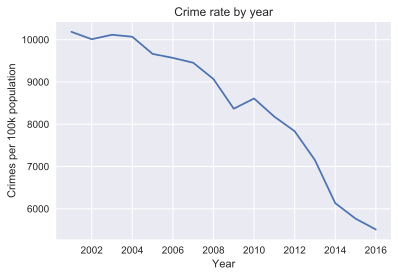

In [14]:
# Redo the plot but this time use the crime rate instead (normalized to population)
plt.figure(figsize=(6,4))
plt.plot(chicago_population['Year'], crimes_per_capita)
plt.xlabel('Year')
plt.ylabel('Crimes per 100k population')
plt.title('Crime rate by year')
plt.show()

<strong>It looks like that crime rates are also going down except for that little bump in 2010 compared to 2009. So generally speaking, Chicago is <br>
getting safer over these years.</strong>

<h3> But what about individual crimes? Maybe certain crimes don't follow the trend. </h3>

In [5]:
# First group by year and count each crime, make a data frame
by_year=crimes.groupby('Year')['Primary Type'].value_counts()
by_year.head()

Year  Primary Type
2001  THEFT           98448
      BATTERY         93051
      NARCOTICS       50318
      BURGLARY        25943
      ROBBERY         18292
Name: Primary Type, dtype: int64

In [6]:
# Unstack to make the second level index columns
by_year=by_year.unstack(level=1, fill_value=0)
by_year.head()

Primary Type  BATTERY  BURGLARY  HOMICIDE  NARCOTICS  ROBBERY  SEX OFFENSE  THEFT  WEAPONS VIOLATION
Year                                                                                                
2001            93051     25943       667      50318    18292         3919  98448               4246
2002            91724     25221       657      49824    17740         3755  95362               4149
2003            87835     25010       604      53763    17235         3528  97804               4199
2004            86966     24517       454      56882    15951         3188  94641               4283
2005            83637     25414       453      55950    15988         3129  84304               4074

In [14]:
# Join the population table
by_year.reset_index(inplace=True)
by_year=by_year.merge(chicago_population, on='Year', how='inner')
by_year.head()

index  Year  BATTERY  BURGLARY  HOMICIDE  NARCOTICS  ROBBERY  SEX OFFENSE  THEFT  WEAPONS VIOLATION  Population
0      0  2001    93051     25943       667      50318    18292         3919  98448               4246     2894988
1      1  2002    91724     25221       657      49824    17740         3755  95362               4149     2881295
2      2  2003    87835     25010       604      53763    17235         3528  97804               4199     2866361
3      3  2004    86966     24517       454      56882    15951         3188  94641               4283     2848996
4      4  2005    83637     25414       453      55950    15988         3129  84304               4074     2824584

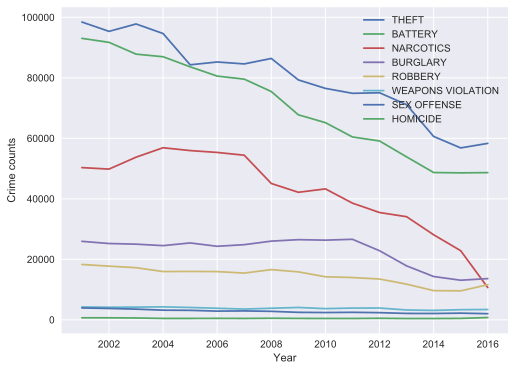

In [18]:
# Plot the 8 crime counts as a time series. First just do the raw count.
plt.figure(figsize=(8, 6))
for c in crime_types:
    plt.plot(by_year['Year'], by_year[c], label=c)
plt.xlabel('Year')
plt.ylabel('Crime counts')
plt.legend()
plt.show()

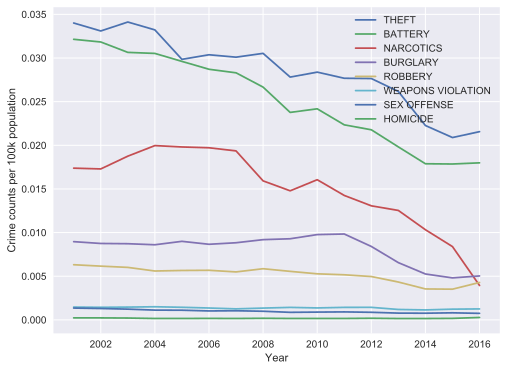

In [19]:
# Now plot each crime rate and compare
plt.figure(figsize=(8, 6))
for c in crime_types:
    plt.plot(by_year['Year'], by_year[c]/by_year['Population'], label=c)
plt.xlabel('Year')
plt.ylabel('Crime counts per 100k population')
plt.legend()
plt.show()

<h3> Are there any correlations between different types of crimes? Maybe some crimes go up and down together.

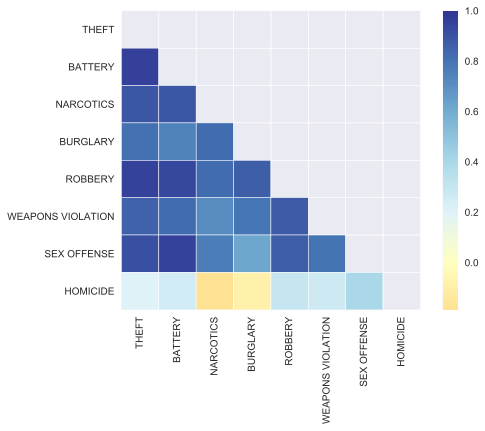

In [18]:
# We can do a heat map of correaltion coefficients between pairs of crimes
corr=by_year[crime_types].corr()
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, square=True, center=0, cmap='RdYlBu', linewidths=0.5, mask=mask)
plt.show()

<strong>As shown by the heatmap, Battery has a strong postive correaltion with Robbery and Sex Offense. Surprisingly, Weapons Violation does not <br>
show a positive correlation with Homicide. 

<h3> By plotting the 8 crimes separately, we can see that: <br>
Theft, Battery, and Narcotics are indeed going down, however, Burglary and Robbery have a spike in year 2016. <br>
Moreover, Weapons violation even goes up from 2016 to 2017. Since some crimes happen less frequenlty than <br>
others, we should plot the bottom three on their own scale to see the trend. </h3>

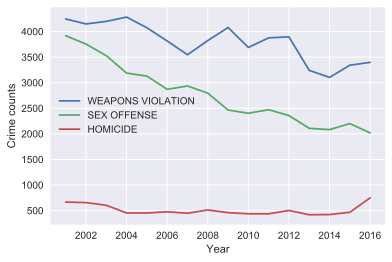

In [21]:
plt.figure(figsize=(6,4))
for c in ['WEAPONS VIOLATION', 'SEX OFFENSE', 'HOMICIDE']:
    plt.plot(by_year['Year'], by_year[c], label=c)
plt.xlabel('Year')
plt.ylabel('Crime counts')
plt.legend()
plt.show()

<h4>Looking at the above graph, we can see the sex offense is going down as a trend despite the fact that for certain years, it has some unusual peaks <br>
The most interesting findings are: first Weapons violation started to climbing quickly since 2014 and as we know that Chicago has somewhat strict <br>
gun laws where people are required to obtain a permit from Illinois state police to purchase a firearm and also they need to pass a background  <br>
check to finally complete the purchase. Then why is the number of weapon violation going up despite all the regulations?<br>
<br>
A little digging up on google has provided a reasonable answer to account for the high numbers of weapon violations. See the following article for<br>
more information: <a href="http://www.chicagotribune.com/news/columnists/glanton/ct-met-gun-control-chicago-dahleen-glanton-20171003-story.html"> Gun laws in Chicago</a>

<strong>Looks like people are buying weapons in neighboring states such as Indiana where a firearm can be purchased without and permit or <br>
background checks. Many firearms confiscated in Chicago were identified to come from neighboring states. But this answer is still not satifying. <br>
It explains where the firearms are from but it doesn't answer the question that what causes the sudden increase since year 2014? More work needs <br>
to be done to try to come up with an answer and it may be related to economy, education and/or poverty levels. </strong>

<strong>The second interesting finding is: what caused the substantial increase in homicide in 2016? With almost 750 homicides,  it is the highest of <br>
all the years analyzed here. Moreover, it coincides with the increase in weapons violations since 2014. Chicago may not be the murder capital in <br>
this country but the number is still alarming. Let's calculate the murder rate per capita in Chicago</strong>

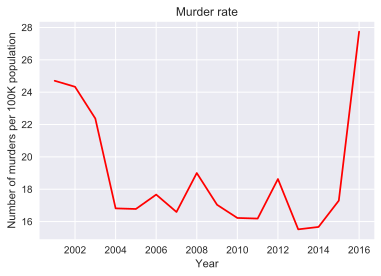

In [22]:
#Let's see the homicide rate per 100,000 people in Chicago
plt.figure(figsize=(6,4))
homicides=crimes[crimes['Primary Type']=='HOMICIDE']
homicides_count=homicides['Primary Type'].resample('A').count()
chicago_pop=2700000      # From google search
homicides_rate_per_100k=homicides_count/(chicago_pop/100000)
homicides_rate_per_100k.plot(color='red')
plt.title('Murder rate')
plt.xlabel('Year')
plt.ylabel('Number of murders per 100K population')
plt.show()

<strong>The sharp peak in 2016 is appalling and that's why I set it to red. With ~750 murders, it averages to 2 people killed everyday in 2016. Compared <br>
to St. Louis (59 per 100K in 2015) or Baltimore (55 per 100K in 2015) , Chicago's murder rate (~28 per 100K) still falls behind, but St. Louis has only  <br> 
1/9 of Chicago's population while Baltimore has a little less than 1/4. Work needs to be done to investigate the truth underlying the bloody murders  <br>
and hopefully the answer will shed light on how to mitigate this worsening situation<br>
This article has some useful information regarding murder rate in the US: <br>
<a href='http://bismarcktribune.com/news/national/the-cities-with-the-highest-murder-rates-in-the-us/collection_5a789407-4d43-5403-ad56-7c47880bda8e.html#30'> 30 Cities with highest murder rate</a></strong>

<strong>Compared to 2013,2014, and 2015, year 2016 has by far the most homicides. Where are these extra homicide cases on the map? Let's plot<br>
2015 and 2016 homicdes on google map side by side and see where the extra crimes are located. Are they spread out in the entire city or <br>
concentrated in some specific areas?</strong>

In [2]:
# Load google static map API key. You need a google API key to use their maps
api_key=open('data/api_key.txt')
gmaps.configure(api_key=api_key.read())
api_key.close()

<strong>To obtain your own API key see the following page:  <a href="https://developers.google.com/maps/documentation/static-maps/">Google API key</a>

We can use community areas to map crime data as choropleth maps. First let's load the community area geojson file.

In [3]:
with open('data/crime/community_areas.geojson') as file:
    community_areas=json.load(file)

In [4]:
community_areas['features'][0]

{'geometry': {'coordinates': [[[[-87.60914087617894, 41.84469250265398],
     [-87.60914874757808, 41.84466159842403],
     [-87.6091611204126, 41.84458961193954],
     [-87.60916766215838, 41.84451717732316],
     [-87.60916860600166, 41.844456260738305],
     [-87.60915012199398, 41.84423871659811],
     [-87.60907241249289, 41.844194738881015],
     [-87.60900627147821, 41.84410646928696],
     [-87.6089650217216, 41.84404345755115],
     [-87.60891566390615, 41.84395529375054],
     [-87.60889980118988, 41.84387361649532],
     [-87.60886701371862, 41.84380438280048],
     [-87.6088514342449, 41.843697606960866],
     [-87.60881089281094, 41.84357184776641],
     [-87.60877127222787, 41.84336451715353],
     [-87.6087215608253, 41.84330772696518],
     [-87.6086722038968, 41.8432195630558],
     [-87.60858152789015, 41.84307466210119],
     [-87.60847385682872, 41.84294847915887],
     [-87.60839135990155, 41.842822455284654],
     [-87.60826740295646, 41.842652243366025],
     [-8

The 'area_num_1' or 'area_numbe' has the community area number for our mapping purpose.

In [4]:
# Define a function to take a list of crimes and assign a color based on an attribute of that community (e.g. income, crimes) 
# and match each color to a community      

def get_colors_from_attr(geo, mini, maxi, attri_dict, color_map):
    colors=[]
    range_=maxi-mini
    for feature in geo['features']:
        area=int(feature['properties']['area_numbe'])
        if area in list(attri_dict.keys()):
            color=color_map((attri_dict[area]-mini)/range_)
            colors.append(to_hex(color, keep_alpha=False))
        else:
            colors.append((0,0,0,0.3))
    return(colors)

Download link for the following <a href='https://www.dropbox.com/s/z43pgiwbsw93gnt/all_crimes_clean.csv?dl=0'>crime data</a>.

In [5]:
# Read all the crimes data containing the community area column
all_crimes=pd.read_csv('data/crime/all_crimes_clean.csv', index_col=0, parse_dates=True)

In [6]:
all_crimes.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6478356 entries, 2001-01-01 00:00:00 to 2017-11-12 23:45:00
Data columns (total 22 columns):
ID                      6478356 non-null int64
Case Number             6478352 non-null object
Date.1                  6478356 non-null object
Block                   6478356 non-null object
IUCR                    6478356 non-null object
Primary Type            6478356 non-null object
Description             6478356 non-null object
Location Description    6475409 non-null object
Arrest                  6478356 non-null bool
Domestic                6478356 non-null bool
Beat                    6478356 non-null int64
District                6478307 non-null float64
Ward                    5863502 non-null float64
Community Area          6478356 non-null int64
FBI Code                6478356 non-null object
X Coordinate            6391699 non-null float64
Y Coordinate            6391699 non-null float64
Year                    6478356 non-null 

In [7]:
# Define a function to make a simple map object centering on Chicago and set the dimensions
def single_map():
    chicago_coord=(41.8781, -87.6298)
    fig=gmaps.figure(display_toolbar=False, center=chicago_coord, zoom_level=11)
    fig._map.layout.width = '450px'    # Set map width
    fig._map.layout.height = '400px'   # Set map height
    return(fig)

In [8]:
# To compare homicides in 2015 and 2016 at the community level, we will use choropleth map
homicide_2015_commu=all_crimes[all_crimes['Primary Type']=='HOMICIDE'].loc['2015', 'Community Area'].value_counts().reset_index()
homicide_2016_commu=all_crimes[all_crimes['Primary Type']=='HOMICIDE'].loc['2016', 'Community Area'].value_counts().reset_index()

In [9]:
homicide_2015_commu.columns=['Community Area', 'Homicide']
homicide_2016_commu.columns=['Community Area', 'Homicide']

In [10]:
# Get the center points for each community serving as info box
community_centers=pd.read_csv('data/crime/community_centers.csv')

In [11]:
community_centers.head()

community  Latitude  Longitude
0          1   42.0100   -87.6691
1          2   42.0044   -87.6939
2          3   41.9666   -87.6558
3          4   41.9727   -87.6873
4          5   41.9477   -87.6839

In [12]:
# Get the names of the community from another file
income=pd.read_csv('data/crime/income_infer.csv')

In [13]:
community_centers['Community Name']=income['Community Name']

In [14]:
community_centers.head()

community  Latitude  Longitude   Community Name
0          1   42.0100   -87.6691      Rogers Park
1          2   42.0044   -87.6939       West Ridge
2          3   41.9666   -87.6558           Uptown
3          4   41.9727   -87.6873   Lincoln Square
4          5   41.9477   -87.6839     North Center

In [15]:
community_set=set(community_centers['community'])
set_year_15=set(homicide_2015_commu['Community Area'])
set_year_16=set(homicide_2016_commu['Community Area'])
missing_in_15=community_set.difference(set_year_15)
missing_in_16=community_set.difference(set_year_16)

In [16]:
missing_df_15=pd.DataFrame({'Community Area': list(missing_in_15), 'Homicide': np.repeat(0, len(missing_in_15))})
missing_df_16=pd.DataFrame({'Community Area': list(missing_in_16), 'Homicide': np.repeat(0, len(missing_in_16))})

In [17]:
homicide_2015_commu=homicide_2015_commu.append(missing_df_15)
homicide_2016_commu=homicide_2016_commu.append(missing_df_16)

In [18]:
len(homicide_2015_commu)==len(homicide_2016_commu)==len(community_set)==77

True

In [19]:
color_map=cm.get_cmap('Reds')

In [20]:
mini=np.concatenate((homicide_2015_commu['Homicide'].values, homicide_2016_commu['Homicide'].values)).min()
maxi=np.concatenate((homicide_2015_commu['Homicide'].values, homicide_2016_commu['Homicide'].values)).max()

colors_2015=get_colors_from_attr(community_areas, mini, maxi, dict(zip(homicide_2015_commu['Community Area'], 
                                                                       homicide_2015_commu['Homicide'])), color_map)
colors_2016=get_colors_from_attr(community_areas, mini, maxi, dict(zip(homicide_2016_commu['Community Area'], 
                                                                       homicide_2015_commu['Homicide'])), color_map)

In [21]:
community_centers=community_centers.merge(homicide_2015_commu, left_on='community', right_on='Community Area')

In [22]:
community_columns=community_centers.columns.tolist()
community_columns[-1]='Homicide 15'
community_centers.columns=community_columns

In [23]:
community_centers=community_centers.merge(homicide_2016_commu, left_on='community', right_on='Community Area')

In [24]:
community_columns=community_centers.columns.tolist()
community_columns[-1]='Homicide 16'
community_centers.columns=community_columns

In [25]:
info_15=[str(i)+'-'+j+'<br>'+'Homicides: '+str(k) + ' in 2015' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], community_centers['Homicide 15'])]

info_16=[str(i)+'-'+j+'<br>'+'Homicides: '+str(k) + ' in 2016' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], community_centers['Homicide 16'])]

In [26]:
# Define a function to draw two maps side by side for comparison
def double_choro_map(communities, centers, colors_1, colors_2, info_box_1, info_box_2, label_1, label_2):
    """
    This function will make two choropleth maps side by side to see comparison
    """
    fig_left=single_map()
    fig_right=single_map()

    legend_template_1='<i style="font-size:20px; color: {color}; vertical-align: top">&#9632;</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto; \
                       vertical_align: -5px"></span> {label}'

    legend_template_2='<head><link href="https://fonts.googleapis.com/icon?family=Material+Icons" \
                       rel="stylesheet"> </head>  \
                       <i class="material-icons" style="font-size:20px; color: {color}; \
                       vertical-align: -5px">fiber_manual_record</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto;"></span> {label}'

    legend_left_1=legend_template_1.format(color='pink', label=label_1)
    legend_left_2=legend_template_2.format(color='blue', label='Info box marker (click to see)')

    legend_right_1=legend_template_1.format(color='pink', label=label_2)
    legend_right_2=legend_template_2.format(color='blue', label='Info box marker (click to see)')

    layer_left =gmaps.geojson_layer(communities, fill_color=colors_1, fill_opacity=0.8, stroke_weight=1)
    layer_right=gmaps.geojson_layer(communities, fill_color=colors_2, fill_opacity=0.8, stroke_weight=1)

    info_layer_left =gmaps.symbol_layer(centers[['Latitude', 'Longitude']], fill_color='blue', 
                                        stroke_color='blue', info_box_content=info_box_1, scale=3)
    info_layer_right=gmaps.symbol_layer(centers[['Latitude', 'Longitude']], fill_color='blue', 
                                        stroke_color='blue', info_box_content=info_box_2, scale=3)

    fig_left.add_layer(layer_left)
    fig_left.add_layer(info_layer_left)
    fig_right.add_layer(layer_right)
    fig_right.add_layer(info_layer_right)

    left_map =widgets.VBox([fig_left,  widgets.HBox([widgets.HTML(legend_left_1),  widgets.HTML(legend_left_2)], 
                                             layout=widgets.Layout(width='100%', justify_content='flex-start'))])
    right_map=widgets.VBox([fig_right, widgets.HBox([widgets.HTML(legend_right_1), widgets.HTML(legend_right_2)], 
                                             layout=widgets.Layout(width='100%', justify_content='flex-start'))])

    return(widgets.HBox([left_map, right_map], layout=widgets.Layout(width='100%', justify_content='flex-start')))

In [ ]:
# Show the maps
double_choro_map(community_areas, community_centers, colors_2015, colors_2016, info_15, info_16, 
                 'Homicide in 2015', 'Homicide, in 2016')

<strong>Since generating an interactive map will drastically increase the size of the notebook, I will demonstrate using screenshots of the interactive map. If you wish to make the interactive map, please download the notebook and execute locally. I will do this for all subsequent maps. </strong>

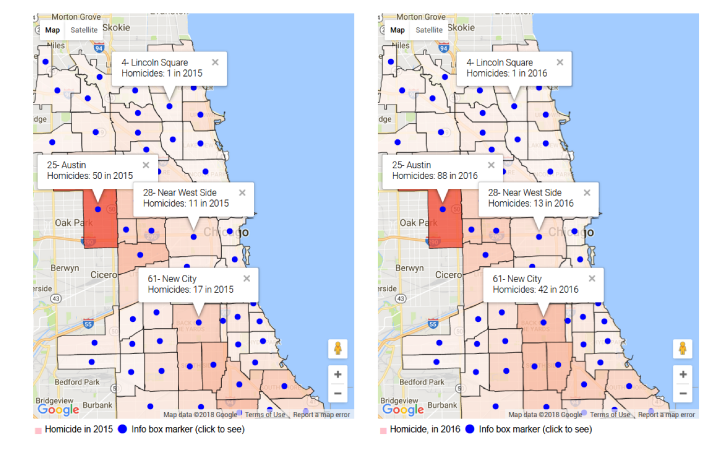

In [6]:
# Load a screenshot of the map
map1=plt.imread('homicide 15 vs 16.png')
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map1)

We can also plot a bar graph to compare 2015 and 2016 by communites.

In [29]:
_2015=homicide_2015_commu.sort_values('Community Area')
_2016=homicide_2016_commu.sort_values('Community Area')

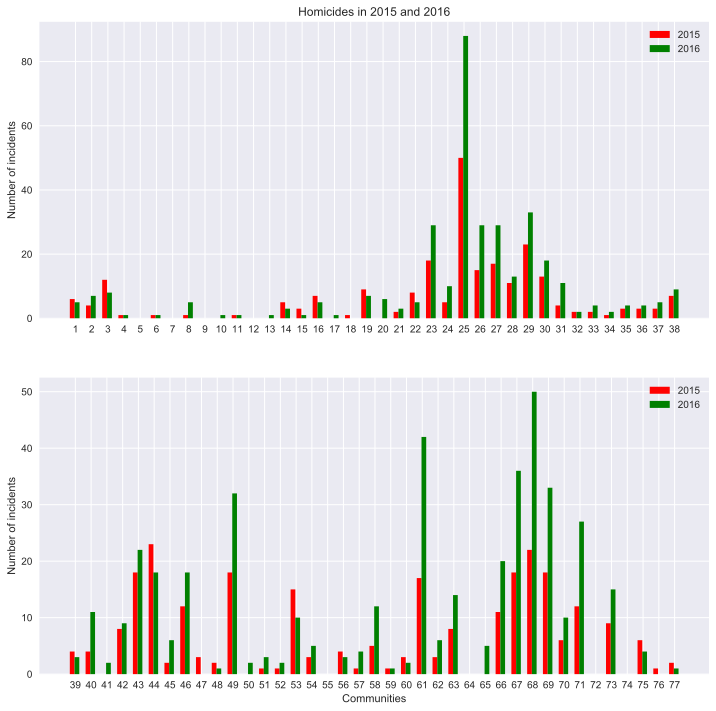

In [30]:
fig2, axes2= plt.subplots(nrows=2, ncols=1, figsize=(12,12))
w=0.3
x1=np.arange(len(_2015))[0:38]
x2=np.arange(len(_2015))[38:]
axes2.flat[0].bar(x1, _2015['Homicide'].values[0:38], width=w, color='r', align='center', label='2015')
axes2.flat[0].bar(x1+w, _2016['Homicide'].values[0:38], width=w, color='g', align='center', label='2016')
axes2.flat[1].bar(x2, _2015['Homicide'].values[38:], width=w, color='r', align='center', label='2015')
axes2.flat[1].bar(x2+w, _2016['Homicide'].values[38:], width=w, color='g', align='center', label='2016')
#ax.bar(x+w, nar_20_by_commu['Narcotics'].values, width=w, color='b', align='center')
axes2.flat[0].set_xticks(x1+0.2)
axes2.flat[0].set_xticklabels((y for y in _2015['Community Area'].values[0:38]))
axes2.flat[0].legend()
axes2.flat[0].set_title('Homicides in 2015 and 2016')
axes2.flat[0].set_ylabel('Number of incidents')
axes2.flat[1].set_xticks(x2+0.2)
axes2.flat[1].set_xticklabels((y for y in _2015['Community Area'].values[38:]))
axes2.flat[1].legend()
axes2.flat[1].set_xlabel('Communities')
axes2.flat[1].set_ylabel('Number of incidents')
plt.show()

<strong>We can now clearly see that in communities: 25, 40, 49, 61, 67, 68, 69, and 71, homicides increased dramatically. These areas are the hotspots. Also, a few interesting areas had no incidents in 2015 but several in 2016 such as: 20, 41, 50, and 65. Moreover, there are some communities where there were no homicides in both years. These are the 'safe zone' in Chicago. They include communities: 5, 7, 9, 12, 55, 64, 72, and 74. Some areas had a decrease in homicides. So the conclusion is: the increase in total homicides are not spread out evenly in the city. There are certainly hotspots that need more attention from authorities and law enforcement. </strong>

<h3>Second Question: Do certain months see more crimes than others? Since temperatures vary and our activities vary according to different months, maybe there is a relationship between month and crimes

In [42]:
# First let's break down the crimes by month and see if certain months have more incidents than others.
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dfs=[]
for crime in crime_types:
    counts=[]
    for i in range(1,13):
        month=crimes[crimes.index.month==i]
        month_crime=month[month['Primary Type']==crime]
        counts.append(len(month_crime))
    dfs.append(pd.DataFrame({'Months': months, 'Number of incidents': counts}))
dfs[0]

Months  Number of incidents
0     Jan                96274
1     Feb                81346
2     Mar                97986
3     Apr               100448
4     May               109250
5     Jun               112789
6     Jul               125942
7     Aug               125159
8     Sep               114740
9     Oct               115398
10    Nov               102727
11    Dec                97376

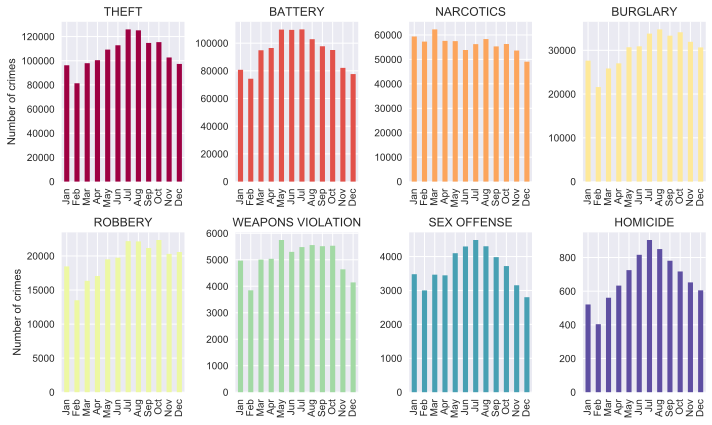

In [50]:
# Let's plot the 8 felonies by month
cmap=cm.get_cmap('Spectral')        # This is a good color map for visualization
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,6))
N=8
for k, df in enumerate(dfs):
    c = cmap(float(k)/(N-1))
    df.plot(kind='bar', x='Months', y='Number of incidents', ax=axes.flat[k], title=crime_types[k], color=c, legend=False)
for i in range(8):
    axes.flat[i].set_xlabel('')
for i in [0, 4]:
    axes.flat[i].set_ylabel('Number of crimes')
plt.tight_layout()
plt.show()

<strong>Interesting finding here is: while all crimes seem to peak around July, Narcotics sees the highest number in March. The high occurences of <br>
crimes around the month of July could be explained by temperature. In warmer month, people have more outside activities thus crimes increase. <br>
So the question is: do all of these crimes mostly occur outdoors? We can plot the location of crimes to find out.</strong>

<strong>When crimes are high in July and low in February, did they happen in the same areas or in different areas? If different, this might indicate<br>
a pattern of crimes in different months of the year. Let's do a choropleth on burglary comparing February and July.</strong>

In [30]:
all_crimes['Month']=all_crimes.index.month

In [31]:
# Get burglary by community for February and July
burg_feb_commu=all_crimes[(all_crimes['Month']==2) & (all_crimes['Primary Type']=='BURGLARY')]['Community Area'] \
                                                                               .value_counts().reset_index()
burg_jul_commu=all_crimes[(all_crimes['Month']==7) & (all_crimes['Primary Type']=='BURGLARY')]['Community Area'] \
                                                                               .value_counts().reset_index()

burg_feb_commu.columns=['Community Area', 'Burglary']
burg_jul_commu.columns=['Community Area', 'Burglary']

burg_feb_commu=burg_feb_commu[burg_feb_commu['Community Area']!=0]
burg_jul_commu=burg_jul_commu[burg_jul_commu['Community Area']!=0]

In [32]:
burg_min=np.concatenate((burg_feb_commu['Burglary'].values, burg_jul_commu['Burglary'].values)).min()
burg_max=np.concatenate((burg_feb_commu['Burglary'].values, burg_jul_commu['Burglary'].values)).max()

In [33]:
# Get colors for February and July using our function
colors_feb=get_colors_from_attr(community_areas, burg_min, burg_max, dict(zip(burg_feb_commu['Community Area'], 
                                                                              burg_feb_commu['Burglary'])), color_map)
colors_jul=get_colors_from_attr(community_areas, burg_min, burg_max, dict(zip(burg_jul_commu['Community Area'], 
                                                                              burg_jul_commu['Burglary'])), color_map)

In [34]:
info_feb=[str(i)+'-'+j+'<br>'+'Burglaries: '+str(k) + ' in February' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], 
                burg_feb_commu.sort_values('Community Area')['Burglary'])]

info_jul=[str(i)+'-'+j+'<br>'+'Burglaries: '+str(k) + ' in July' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], 
                burg_jul_commu.sort_values('Community Area')['Burglary'])]

In [ ]:
# Show the maps. Execute this after downloading notebook and data file
double_choro_map(community_areas, community_centers, colors_feb, colors_jul, info_feb, info_jul, 
                 'Burglaries in Februray', 'Burglaries in July')

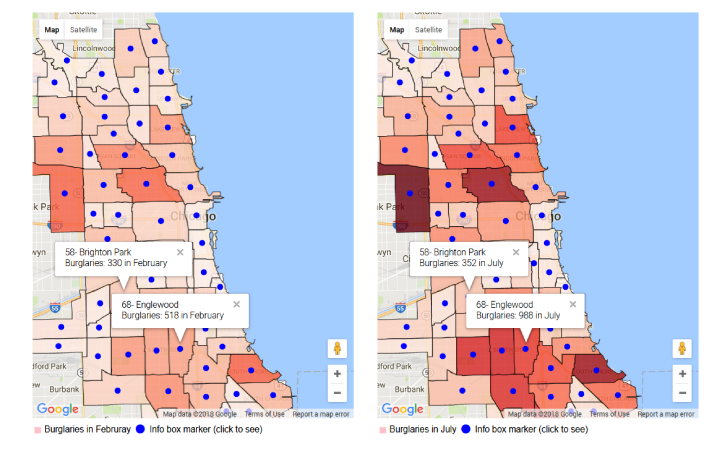

In [7]:
# Load a local screenshot of the above interactive map
map2=plt.imread('burglary Feb vs Jul.png')
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map2)

<strong>Lookst like some regions get hit more in the summer than others. For example, in Brighton Park, there is no <br>
obvious difference between Februray and July (330 vs 352); whereas in West Englewood, in July, the incidents of burglary<br>
are more than double that of February.</strong>

In [49]:
# Get the top 5 locations for all crimes
crime_loc_counts=[]
for c in crime_types:
    crime_type=crimes[crimes['Primary Type']==c]
    crime_loc=crime_type['Location Description'].value_counts()[0:5]
    crime_loc_counts.append(crime_loc)

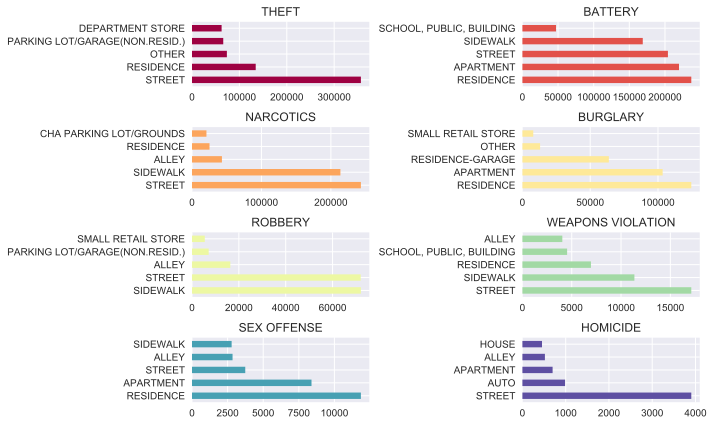

In [58]:
# Plot locations for all crimes
fig, axes=plt.subplots(nrows=4, ncols=2, figsize=(10,6))

for i, s in enumerate(crime_loc_counts):
    c=cmap(float(i)/(N-1))
    s.plot(kind='barh', color=c, ax=axes.flat[i], title=crime_types[i])
plt.tight_layout()
plt.show()

<strong>For most crimes, the top location is Street, however, for Battery and Sex offense, they mostly happen indoors (residence or apartment). While <br>
it's no surprise to see that most Burglary happen at residence or apartment by definition. What's puzzling here is that for Narcotics, the top <br>
locations are 'Street' and 'Sidewalk', then why do most Narcotics incidents happen in February and March. In Chicago, those two months are pretty <br>
cold. We can plot average temperatures by month to verify that.</strong>

<strong>Narcotics crimes peaked in March and were the lowest in December. Let's compare March and December locations on a map to see if there is a difference. </strong>

In [36]:
# Get narcotics by community for March and August
narc_mar_commu=all_crimes[(all_crimes['Month']==3) & (all_crimes['Primary Type']=='NARCOTICS')]['Community Area'] \
                                                                               .value_counts().reset_index()
narc_dec_commu=all_crimes[(all_crimes['Month']==12) & (all_crimes['Primary Type']=='NARCOTICS')]['Community Area'] \
                                                                               .value_counts().reset_index()

narc_mar_commu.columns=['Community Area', 'Narcotics']
narc_dec_commu.columns=['Community Area', 'Narcotics']

narc_mar_commu=narc_mar_commu[narc_mar_commu['Community Area']!=0]
narc_dec_commu=narc_dec_commu[narc_dec_commu['Community Area']!=0]

In [37]:
narc_min=np.concatenate((narc_mar_commu['Narcotics'].values, narc_dec_commu['Narcotics'].values)).min()
narc_max=np.concatenate((narc_mar_commu['Narcotics'].values, narc_dec_commu['Narcotics'].values)).max()

In [38]:
# Get colors for March and August using our function
colors_mar=get_colors_from_attr(community_areas, narc_min, narc_max, dict(zip(narc_mar_commu['Community Area'], 
                                                                              narc_mar_commu['Narcotics'])), color_map)
colors_dec=get_colors_from_attr(community_areas, narc_min, narc_max, dict(zip(narc_dec_commu['Community Area'], 
                                                                              narc_dec_commu['Narcotics'])), color_map)

In [39]:
info_mar=[str(i)+'-'+j+'<br>'+'Narcotics: '+str(k) + ' in March' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], 
                narc_mar_commu.sort_values('Community Area')['Narcotics'])]

info_dec=[str(i)+'-'+j+'<br>'+'Narcotics: '+str(k) + ' in December' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], 
                narc_dec_commu.sort_values('Community Area')['Narcotics'])]

In [ ]:
# Show the maps. Download and execute locally.
double_choro_map(community_areas, community_centers, colors_mar, colors_dec, info_mar, info_dec,
                 'Narcotics in March', 'Narcotics in December')

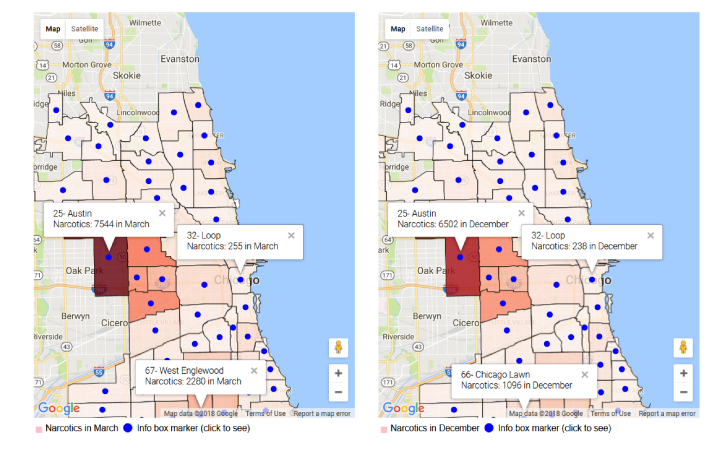

In [9]:
# Load a local screenshot of the above interactive map
map3=plt.imread('narcotics in mar and dec.png')
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map3)

In [41]:
# Let's do a statistical test to show that for Austin (community 25), there is more narcotics in March than in December.
# But for East Garfield Park, there no difference between March and December
narc_mar_austin=all_crimes[(all_crimes['Month']==3) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==25)]['Primary Type'].resample('A').count()
narc_dec_austin=all_crimes[(all_crimes['Month']==12) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==25)]['Primary Type'].resample('A').count()
narc_mar_eastgar=all_crimes[(all_crimes['Month']==3) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==27)]['Primary Type'].resample('A').count()
narc_dec_eastgar=all_crimes[(all_crimes['Month']==12) & (all_crimes['Primary Type']=='NARCOTICS') & \
                           (all_crimes['Community Area']==27)]['Primary Type'].resample('A').count()

In [42]:
df1=pd.concat([narc_mar_austin, narc_dec_austin, narc_mar_eastgar, narc_dec_eastgar], axis=1)

In [43]:
df1

Primary Type  Primary Type  Primary Type  Primary Type
Date                                                              
2001-12-31             6           4.0             1           NaN
2002-12-31            17         588.0            12         192.0
2003-12-31           565         545.0           197         174.0
2004-12-31           782         532.0           178         194.0
2005-12-31           737         680.0           185         163.0
2006-12-31           580         588.0           145         161.0
2007-12-31           724         547.0           209         160.0
2008-12-31           576         443.0           124         126.0
2009-12-31           596         485.0           123         132.0
2010-12-31           603         389.0           139         120.0
2011-12-31           459         444.0           119         110.0
2012-12-31           482         329.0           148          70.0
2013-12-31           431         383.0            98         156.0
2014-12-31           357         246.0           164         160.0
2015-12-31           316         159.0           158          55.0
2016-12-31           193         140.0            45          45.0
2017-12-31           120           NaN            85           NaN

In [44]:
# Let's get rid of 2001, 2002, and 2017 because of the outliers and also nan values
df1=df1.iloc[2:16, :]

In [59]:
df1.columns=['Austin March', 'Austin December', 'East Garfield March', 'East Garfield December']

In [60]:
df1

Austin March  Austin December  East Garfield March  East Garfield December
Date                                                                                  
2003-12-31           565            545.0                  197                   174.0
2004-12-31           782            532.0                  178                   194.0
2005-12-31           737            680.0                  185                   163.0
2006-12-31           580            588.0                  145                   161.0
2007-12-31           724            547.0                  209                   160.0
2008-12-31           576            443.0                  124                   126.0
2009-12-31           596            485.0                  123                   132.0
2010-12-31           603            389.0                  139                   120.0
2011-12-31           459            444.0                  119                   110.0
2012-12-31           482            329.0                  148                    70.0
2013-12-31           431            383.0                   98                   156.0
2014-12-31           357            246.0                  164                   160.0
2015-12-31           316            159.0                  158                    55.0
2016-12-31           193            140.0                   45                    45.0

In [61]:
df1.mean()

Austin March              528.642857
Austin December           422.142857
East Garfield March       145.142857
East Garfield December    130.428571
dtype: float64

In [73]:
# Now let's compare the March and December for Austin and East Garfield Park
austin_test=sm_ttest(df1['Austin March'].values, df1['Austin December'].values, alternative='larger')

In [74]:
# Now let's compare the March and December for Austin and East Garfield Park
eastgar_test=sm_ttest(df1['East Garfield March'].values, df1['East Garfield December'].values, alternative='two-sided')

In [78]:
df2=pd.DataFrame({'Austin': austin_test[1], 'East Garfield Park': eastgar_test[1]}, index=['p value'])

In [79]:
df2.index.name='Compare March to December'

In [80]:
df2

Austin  East Garfield Park
Compare March to December                              
p value                    0.048766            0.389275

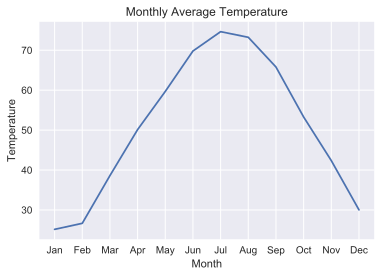

In [59]:
# Plot average temperatures by month in Chicago
temps=[]
for i in range(1,13):
    month=crimes[crimes.index.month==i]
    month_temp_avg=month['TAVG'].mean()
    temps.append(month_temp_avg)
plt.figure(figsize=(6,4))
monthly_avg_temp=pd.Series(temps, index=months)
monthly_avg_temp.plot()
plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.xticks(np.arange(12), months)
plt.show()

<strong>As shown from the figure, February and March indeed have very low temperatures. We can also make a histogram to see if most crimes occur<br>
in higher temperatures</strong>

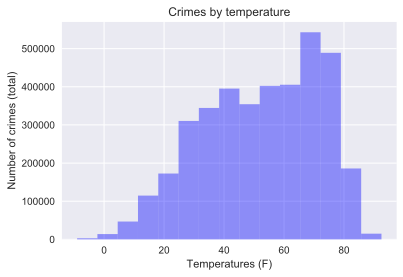

In [60]:
# We will use seaborn to plot the histogram as it looks better and privides more controls
plt.figure(figsize=(6,4))
sns.distplot(crimes['TAVG'], bins=15, kde=False, color='blue')
plt.xlabel('Temperatures (F)')
plt.ylabel('Number of crimes (total)')
plt.title('Crimes by temperature')
plt.show()

<strong>We can see from the above figure, most crimes happen in higher temperatures around 70 degrees. Another interesting finding here is that :<br>
at very high temperatures (>80 degrees), crimes also drop.<br>
Since most crimes do occur at higher temperatures, the abnormally high incident counts of Narcotics in colder month is intriguing. More work and <br>
data are needed to answer that question. Let's do a histogram for each individual crime to see this phenomenon.</strong>

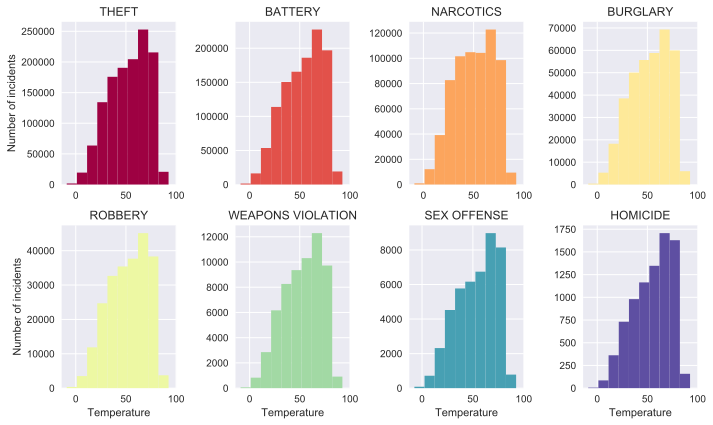

In [61]:
fig2, axes2=plt.subplots(nrows=2, ncols=4, figsize=(10,6))
for i, c in enumerate(crime_types):
    crime_type=crimes[crimes['Primary Type']==c]
    color=cmap(float(i)/(N-1))
    crime_type['TAVG'].plot.hist(bins=10, ax=axes2.flat[i], color=color, title=c)
    axes2.flat[i].set_xticks(np.linspace(0,100, 3))
    axes2.flat[i].set_ylabel('')
axes2.flat[0].set_ylabel('Number of incidents')
axes2.flat[4].set_ylabel('Number of incidents')
axes2.flat[4].set_xlabel('Temperature')
axes2.flat[5].set_xlabel('Temperature')
axes2.flat[6].set_xlabel('Temperature')
axes2.flat[7].set_xlabel('Temperature')
plt.tight_layout()
plt.show()

<strong>Look at the unusual shoulder for Narcotics around 30-40 degrees. It confirms the finding when doing the monthly plots</strong>

<h3> Third question: do certain days of the week see more crimes than others? Since temperature shouldn't vary that much during a week, something
else may be involved.

In [52]:
# We can break down all crimes by day of the week and see their distributions
weekdays=['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
weekly_dfs=[]
for crime in crime_types:
    counts=[]
    for i in range(0,7):
        weekly=crimes[crimes.index.weekday==i]
        weekly_crime=weekly[weekly['Primary Type']==crime]
        counts.append(len(weekly_crime))
    weekly_dfs.append(pd.DataFrame({'Weekday': weekdays, 'Number of incidents': counts}))
weekly_dfs[0]

Number of incidents Weekday
0               185298      Mo
1               185577      Tu
2               186867      We
3               183596      Th
4               198337      Fr
5               180680      Sa
6               159080      Su

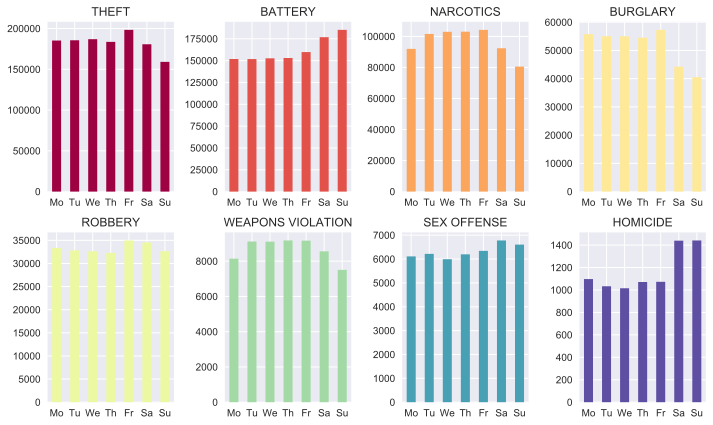

In [63]:
fig3, axes3= plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
N=8
for k, df in enumerate(weekly_dfs):
    c = cmap(float(k)/(N-1))
    df.plot.bar(x='Weekday', y='Number of incidents', ax=axes3.flat[k], title=crime_types[k], color=c, legend=False, xticks=[])
for i in range(8):
    axes3.flat[i].set_xlabel('')
plt.tight_layout()
plt.show()

<strong>From this plot, we can extract some useful information. First, battery seems to be high on the weekend and it makes sense if we also look at <br>
the location plot above. Battery mostly happens at residence or apartment and people are more likely to be home on the weekend. On the other <br>
hand, Burglary seems to be lower on the weekend. It also makes sense because when most people are home, burglary is less likely to happen. <br>
Theft  is the highest on Friday while homicide is the highest on Sunday maybe when there is no school. Other information is needed to dig further <br> 
for this pattern</strong>

<strong>Where are all the sex offenses located? Parents are concerned about sex offenders in the city when choosing schools for their children. Let's see which communities have the most sex offenses. </strong>

In [45]:
all_sex_off=all_crimes[all_crimes['Primary Type']=='SEX OFFENSE']

In [46]:
all_sex_off_by_commu=all_sex_off['Community Area'].value_counts().reset_index()
all_sex_off_by_commu.columns=['Community', 'Sex Offense']
all_sex_off_by_commu=all_sex_off_by_commu[all_sex_off_by_commu['Community']!=0]

In [47]:
# Get colors to plot the choropleth
sex_min=all_sex_off_by_commu['Sex Offense'].min()
sex_max=all_sex_off_by_commu['Sex Offense'].max()
sex_off_colors=get_colors_from_attr(community_areas, sex_min, sex_max, dict(zip(all_sex_off_by_commu['Community'], 
                                                                                all_sex_off_by_commu['Sex Offense'])), color_map)

In [48]:
# Set up info box
info_sex=[str(i)+'-'+j+'<br>'+'Sex Offenses: ' +str(k) + ' cases from 2001 to 2017' for i, j, k \
         in zip(community_centers['community'], community_centers['Community Name'], 
                all_sex_off_by_commu.sort_values('Community')['Sex Offense'])]

In [ ]:
# Execute this locally after downloading
legend_template_1='<i style="font-size:20px; color: {color}; vertical-align: top">&#9632;</i>  \
                       <span class="nav-text" style="color:{color}; font-family: roboto; \
                       vertical_align: -5px"></span> {label}'

legend_template_2='<head><link href="https://fonts.googleapis.com/icon?family=Material+Icons" \
                    rel="stylesheet"> </head>  \
                   <i class="material-icons" style="font-size:20px; color: {color}; \
                    vertical-align: -5px">fiber_manual_record</i>  \
                   <span class="nav-text" style="color:{color}; font-family: roboto;"></span> {label}'

legend_1=legend_template_1.format(color='pink', label='Sex Offenses')

sex_off=single_map()
sex_layer=gmaps.geojson_layer(community_areas, fill_color=sex_off_colors, fill_opacity=0.8, stroke_weight=1)
info_layer_sex=gmaps.symbol_layer(community_centers[['Latitude', 'Longitude']], fill_color='blue', stroke_color='blue',
                                 info_box_content=info_sex, scale=3)
sex_off.add_layer(sex_layer)
sex_off.add_layer(info_layer_sex)

widgets.VBox([sex_off, widgets.HTML(legend_1)])

<strong>Using community 54: Riverdale as an example, its education levels are low, median income levels are low and poverty levels are high; and yet it has a very low level of sex offenses. But the total population in Riverdale is also not high. Let's plot the sex offense per 10000 people and also combine poverty data from 2011 to 2015.</strong>

In [50]:
sex_11_15=all_crimes[all_crimes['Primary Type']=='SEX OFFENSE'].loc['2011':'2015', :]
sex_11_15_by_commu=sex_11_15['Community Area'].value_counts().reset_index()

In [51]:
sex_11_15_by_commu.columns=['Community Area', 'Sex Offense']
sex_11_15_by_commu=sex_11_15_by_commu.sort_values('Community Area')

In [52]:
# Calcualte average sex offense between 2011 and 2015
sex_11_15_by_commu['Sex Offense']=sex_11_15_by_commu['Sex Offense']/5

In [53]:
# Load poverty data
poverty_11_15=pd.read_csv('data/crime/poverty_infer.csv', index_col=0)

In [54]:
poverty_11_15.head()

Community Name  Community Area  % Below poverty level  Total pop
0      Rogers Park               1                   26.0      51270
1       West Ridge               2                   22.0      71100
2           Uptown               3                   24.0      53760
3   Lincoln Square               4                   12.0      40177
4     North Center               5                    6.0      34568

In [55]:
poverty_11_15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 4 columns):
Community Name           77 non-null object
Community Area           77 non-null int64
% Below poverty level    77 non-null float64
Total pop                77 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ KB


In [60]:
per_100k=poverty_11_15['Total pop']/100000

In [61]:
type(per_100k)

pandas.core.series.Series

In [62]:
sex_11_15_by_commu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 15 to 30
Data columns (total 2 columns):
Community Area    77 non-null int64
Sex Offense       77 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


In [63]:
sex_per_100k=[i/j for i, j in zip(sex_11_15_by_commu['Sex Offense'], per_100k)]

In [64]:
sex_per_100k=np.around(sex_per_100k, 1)

In [65]:
sex_per_100k[0:5]

array([43.3, 21.9, 38.3, 34.8, 21.4])

In [68]:
sex_11_15_by_commu['Sex offense per 100000 pop']=sex_per_100k

In [71]:
sex_11_15_by_commu.head()

Community Area  Sex Offense  Sex offense per 100000 pop
15               1         22.2                        43.3
27               2         15.6                        21.9
19               3         20.6                        38.3
32               4         14.0                        34.8
51               5          7.4                        21.4

In [73]:
sex_11_15_min=sex_11_15_by_commu['Sex offense per 100000 pop'].min()
sex_11_15_max=sex_11_15_by_commu['Sex offense per 100000 pop'].max()
poverty_11_15_min=poverty_11_15['% Below poverty level'].min()
poverty_11_15_max=poverty_11_15['% Below poverty level'].max()
sex_11_15_colors=get_colors_from_attr(community_areas, sex_11_15_min, sex_11_15_max, 
                                      dict(zip(sex_11_15_by_commu['Community Area'], 
                                               sex_11_15_by_commu['Sex offense per 100000 pop'])), color_map)
poverty_11_15_colors=get_colors_from_attr(community_areas, poverty_11_15_min, poverty_11_15_max, 
                                          dict(zip(poverty_11_15['Community Area'], 
                                                   poverty_11_15['% Below poverty level'])), color_map)

In [75]:
# Set up info box contents
sex_11_15_info=[str(i)+'-'+j+'<br>'+'Sex offenses per 10k: ' +str(k) + ' between 2011 and 2015' for i, j, k \
                in zip(community_centers['community'], community_centers['Community Name'], 
                sex_11_15_by_commu['Sex offense per 100000 pop'])]
poverty_11_15_info=[str(i)+'-'+j+'<br>'+'% below poverty level: ' +str(k) + ' between 2011 and 2015' for i, j, k \
                    in zip(community_centers['community'], community_centers['Community Name'], 
                    poverty_11_15['% Below poverty level'])]

In [ ]:
# Show the map. Execute locally after downloading.
double_choro_map(community_areas, community_centers, sex_11_15_colors, poverty_11_15_colors, sex_11_15_info, poverty_11_15_info,
                 'Sex offense between 2011 and 2015', 'Poverty level between 2011 and 2015')

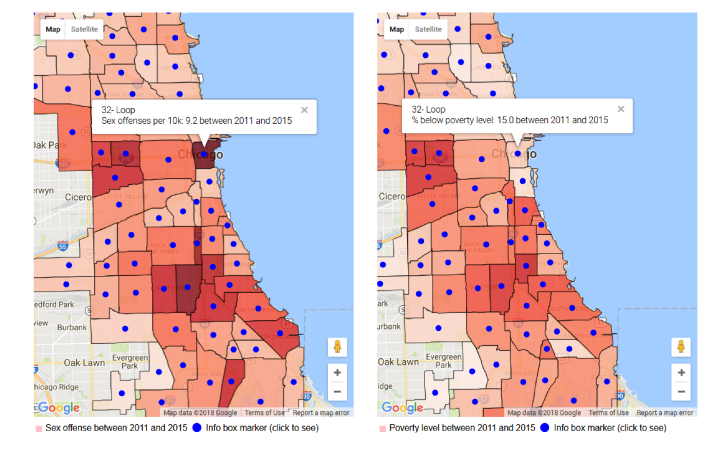

In [10]:
# Load a local screenshot of the above interactive map
map4=plt.imread('sex offense vs poverty level 2011 to 2015.png')
plt.figure(figsize=(12, 12), dpi=300)
plt.axis('off')
plt.grid(False)
plt.imshow(map4)

<strong>From the above map, we can see that in most communities the rate of sex offense is correlated with percentage below poverty level. However, in community 32: the Loop, it's not the case. The 9.2 sex offense per 10000 people is very high in all of Chicago and yet the percentage below poverty is pretty low (only 15%). What could be the reason for this? More information is needed to try to answer this question. </strong>